# Convert given array as a sparse connected fcn

- Input node cannot be connected to the others
- But all output nodes should be connected to at least one hidden node or input node

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from graphtorch import SparseMatrix, SparseModel
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
def get_params(model) : 
    params = []
    for param in model.parameters():
        if param.requires_grad:
            params.append(param.data.numpy()[0][0])        
    return np.array(params)

## Connection also represents its acitvation function
- 0 : not connected
- 1 : linear 
- 2 : ReLU
- 3 : Sigmoid
- and so on..

**this index can be changed**

In [3]:
# 0 : Not connected
# 1 : linear
# 2 : ReLU
# 3 : Sigmoid
activations = [None, None, nn.ReLU(), nn.Sigmoid()]

# References
- [Concatenate layer output with additional input data](https://discuss.pytorch.org/t/concatenate-layer-output-with-additional-input-data/20462)
- [When should I use nn.ModuleList and when should I use nn.Sequential?](https://discuss.pytorch.org/t/when-should-i-use-nn-modulelist-and-when-should-i-use-nn-sequential/5463/2)

# Examples

## Example 1

![](img/example1_1.png)

![](img/example1_2.png)

In [4]:
mat1 = np.array([[0,2,0,0,2,0,0,0,0,0],
                [2,0,2,0,0,0,0,0,0,0],
                [0,2,0,2,0,0,0,0,0,0],
                [0,0,0,0,0,1,1,0,0,0],
                [0,0,0,0,0,0,1,1,0,0],
                [0,0,0,0,0,0,0,0,0,3],
                [0,0,0,0,0,0,0,0,3,0]])  
in_dim = 5   
out_dim = 2  
mat_wann1 = SparseMatrix(mat1, in_dim, out_dim)  

In [5]:
# first position represents row : FROM
mat1[0]

array([0, 2, 0, 0, 2, 0, 0, 0, 0, 0])

In [6]:
# second position represents column : TO
mat1[:, 0]

array([0, 2, 0, 0, 0, 0, 0])

In [7]:
# get destinations of input layer
mat1[:mat_wann1.num_hidden_nodes, :in_dim]

array([[0, 2, 0, 0, 2],
       [2, 0, 2, 0, 0],
       [0, 2, 0, 2, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [8]:
# num of total hidden nodes
mat_wann1.num_hidden_nodes

5

In [9]:
# get number of hidden layers and its node index
mat_wann1.hidden_dim

[3, 2]

In [10]:
# get total number of connections
mat_wann1.connection_count

12

In [11]:
constant_weight = 1 
model = SparseModel(mat_wann1, activations, constant_weight)

numpy_input = np.array([[1,2,3,4,5],  
                        [6,7,8,9,10],  
                        [11,12,13,14,15]])      
numpy_input = torch.from_numpy(numpy_input).float()  

output, nodes = model(numpy_input)  

In [12]:
output

tensor([[1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000]], grad_fn=<CatBackward>)

In [13]:
nodes

{'hidden_0': tensor([[ 7.],
         [17.],
         [27.]], grad_fn=<AddBackward0>), 'hidden_1': tensor([[ 4.],
         [14.],
         [24.]], grad_fn=<AddBackward0>), 'hidden_2': tensor([[ 6.],
         [16.],
         [26.]], grad_fn=<AddBackward0>), 'hidden_3': tensor([[11.],
         [31.],
         [51.]], grad_fn=<AddBackward0>), 'hidden_4': tensor([[10.],
         [30.],
         [50.]], grad_fn=<AddBackward0>), 'output_0': tensor([[1.0000],
         [1.0000],
         [1.0000]], grad_fn=<SigmoidBackward>), 'output_1': tensor([[1.0000],
         [1.0000],
         [1.0000]], grad_fn=<SigmoidBackward>)}

In [14]:
# train model to double the current output
numpy_output = np.array([[1.9999, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]])
numpy_output = torch.from_numpy(numpy_output).float()  
numpy_output

tensor([[1.9999, 2.0000],
        [2.0000, 2.0000],
        [2.0000, 2.0000]])

In [43]:
epochs = 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters()) 

params = None
loss_hist = []

model.train()
for idx, epoch in enumerate(range(epochs)) : 

    optimizer.zero_grad()
    output, nodes = model(numpy_input)  
    loss = criterion(output, numpy_output)
    loss.backward()
    optimizer.step()
    
    # get params, loss
    if idx == 0 :
        params = get_params(model)
    else :
        params = np.append(params, get_params(model))
    loss_hist.append(loss.item())
    
params = params.reshape(epochs, -1)

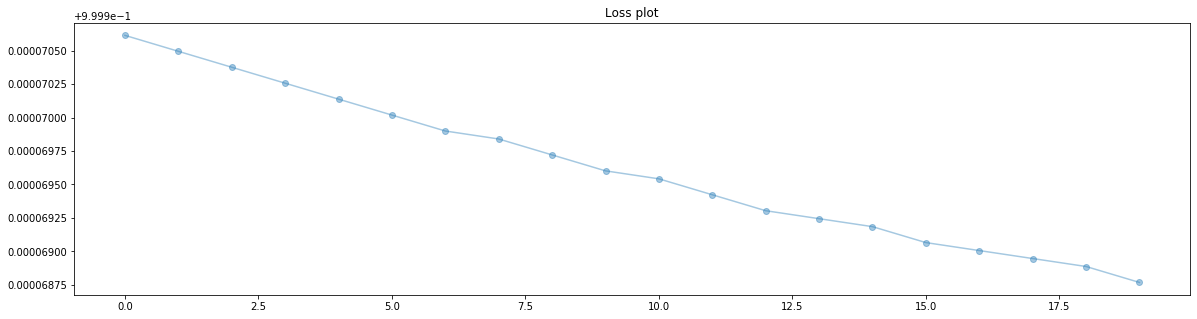

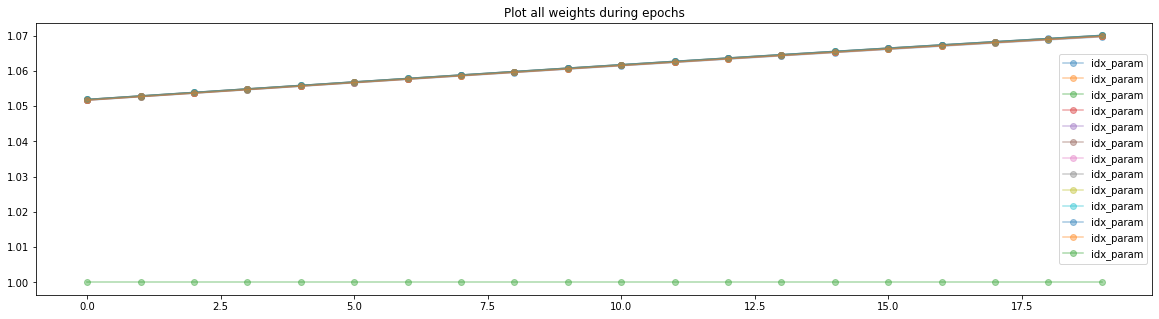

In [48]:
plt.figure(figsize=(20, 5))
plt.plot(loss_hist, label='loss', alpha=0.4, marker='o')
plt.title('Loss plot')
plt.show()

plt.figure(figsize=(20,5))
for idx_param in range(params.shape[1]) : 
    plt.plot(params[:, idx_param], label='idx_param', alpha=0.4, marker='o')
plt.title('Plot all weights during epochs')
plt.legend()
plt.show()

## Example 2

![](img/example2_1.png)

![](img/example2_2.png)

In [7]:
mat2 = np.array([[2,0,0,0,0,0],
                [0,0,0,3,0,1]])
in_dim = 5
out_dim = 1
mat_wann2 = SparseMatrix(mat2, in_dim, out_dim)  

In [8]:
constant_weight = 1 
model = SparseModel(mat_wann2, activations, constant_weight)

numpy_input = np.array([[1,2,3,4,5],  
                        [6,7,8,9,10],  
                        [11,12,13,14,15]]) 

numpy_input = torch.from_numpy(numpy_input).float()  
output, nodes = model(numpy_input)  

In [9]:
output

tensor([[ 1.9820],
        [ 6.9999],
        [12.0000]], grad_fn=<AddBackward0>)

In [10]:
nodes

{'hidden_0': tensor([[ 1.],
         [ 6.],
         [11.]], grad_fn=<ReluBackward0>), 'output_0': tensor([[ 1.9820],
         [ 6.9999],
         [12.0000]], grad_fn=<AddBackward0>)}

## Example 3

![](img/example3_1.png)


In [11]:
mat3 = np.array([[2,0,0,3,0],
                [0,0,0,0,1]])    
in_dim = 5  
out_dim = 2    
mat_wann3 = SparseMatrix(mat3, in_dim, out_dim)

In [12]:
constant_weight = 1 
model = SparseModel(mat_wann3, activations, constant_weight)

numpy_input = np.array([[1,2,3,4,5],  
                        [6,7,8,9,10],  
                        [11,12,13,14,15]]) 

numpy_input = torch.from_numpy(numpy_input).float()  
output, nodes = model(numpy_input)  

In [13]:
output

tensor([[ 1.9820,  5.0000],
        [ 6.9999, 10.0000],
        [12.0000, 15.0000]], grad_fn=<CatBackward>)

In [14]:
nodes

{'output_0': tensor([[ 1.9820],
         [ 6.9999],
         [12.0000]], grad_fn=<AddBackward0>), 'output_1': tensor([[ 5.],
         [10.],
         [15.]], grad_fn=<MmBackward>)}

## Example 4

![](img/example4_1.png)


In [15]:
mat4 = np.array([[3,0,1,0,0],
                [0,3,0,0,0],
                [0,0,0,2,0],
                [0,0,0,0,2],
                [0,0,1,2,0],
                [0,0,1,0,0]])
in_dim = 3
out_dim = 4
mat_wann4 = SparseMatrix(mat4, in_dim, out_dim)

In [16]:
constant_weight = 1 
model = SparseModel(mat_wann4, activations, constant_weight)

numpy_input = np.array([[1,2,3,4,5],  
                        [6,7,8,9,10],  
                        [11,12,13,14,15]]) 

numpy_input = torch.from_numpy(numpy_input).float()  
output, nodes = model(numpy_input)  

In [17]:
output

tensor([[ 3.7311,  0.8808,  6.7311,  3.0000],
        [ 8.9975,  0.9991, 16.9975,  8.0000],
        [14.0000,  1.0000, 27.0000, 13.0000]], grad_fn=<CatBackward>)

In [18]:
nodes

{'hidden_0': tensor([[ 3.7311],
         [ 8.9975],
         [14.0000]], grad_fn=<AddBackward0>), 'hidden_1': tensor([[0.8808],
         [0.9991],
         [1.0000]], grad_fn=<SigmoidBackward>), 'output_0': tensor([[ 3.7311],
         [ 8.9975],
         [14.0000]], grad_fn=<ReluBackward0>), 'output_1': tensor([[0.8808],
         [0.9991],
         [1.0000]], grad_fn=<ReluBackward0>), 'output_2': tensor([[ 6.7311],
         [16.9975],
         [27.0000]], grad_fn=<AddBackward0>), 'output_3': tensor([[ 3.],
         [ 8.],
         [13.]], grad_fn=<MmBackward>)}

## Example 5

![](img/example5_1.png)


In [19]:
mat5 = np.array([[0,2,0,0,2,0,0,0,0,0],
                [2,0,2,0,0,0,0,0,0,0],
                [0,2,0,2,0,0,0,0,0,0],
                [0,0,0,0,0,1,1,0,0,0],
                [0,0,0,2,0,0,1,1,0,0],
                [0,0,0,0,0,0,0,0,0,3],
                [0,0,0,0,0,0,0,0,3,0]])
in_dim = 5
out_dim = 2
mat_wann5 = SparseMatrix(mat5, in_dim, out_dim)

In [20]:
constant_weight = 1 
model = SparseModel(mat_wann5, activations, constant_weight)

numpy_input = np.array([[1,2,3,4,5],  
                        [6,7,8,9,10],  
                        [11,12,13,14,15]]) 

numpy_input = torch.from_numpy(numpy_input).float()  
output, nodes = model(numpy_input)  

In [21]:
output

tensor([[1.0000, 1.0000],
        [1.0000, 1.0000],
        [1.0000, 1.0000]], grad_fn=<CatBackward>)

In [22]:
nodes

{'hidden_0': tensor([[ 7.],
         [17.],
         [27.]], grad_fn=<AddBackward0>), 'hidden_1': tensor([[ 4.],
         [14.],
         [24.]], grad_fn=<AddBackward0>), 'hidden_2': tensor([[ 6.],
         [16.],
         [26.]], grad_fn=<AddBackward0>), 'hidden_3': tensor([[11.],
         [31.],
         [51.]], grad_fn=<AddBackward0>), 'hidden_4': tensor([[14.],
         [39.],
         [64.]], grad_fn=<AddBackward0>), 'output_0': tensor([[1.0000],
         [1.0000],
         [1.0000]], grad_fn=<SigmoidBackward>), 'output_1': tensor([[1.0000],
         [1.0000],
         [1.0000]], grad_fn=<SigmoidBackward>)}